# Comparing counts between >2x2 categories (unrelated subjects)

We will explore how we can compare the counts for more than 2 x 2 categories for unrelated subjects

![test_count_chisq.png](images/test_count_chisq.png)

---
## Data preparation

We will be using a dataset from a survey done on undergraduate students at the University of Adelaide. For details see: https://vincentarelbundock.github.io/Rdatasets/doc/MASS/survey.html

We will focus on the self-reported response on their frequency of smoking and their level of exercise
- `Exercise`: None, Some, Freq
- `Smoking`: Never, Occas, Regul, Heavy

In [1]:
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/survey.csv")

smoke_exercise <- data %>% 
                  mutate(Smoke = fct_relevel(Smoke, c("Never","Occas","Regul","Heavy")),
                         Exer = fct_relevel(Exer, c("None","Some","Freq"))) %>%
                         rename(Smoking=Smoke, Exercise=Exer) %>%
                         select(Exercise, Smoking) %>%
                  drop_na()

head(smoke_exercise)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

New names:
* `` -> ...1

Rows: 237 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Sex, W.Hnd, Fold, Clap, Exer, Smoke, M.I
dbl (6): ...1, Wr.Hnd, NW.Hnd, Pulse, Height, Age

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Exercise,Smoking
<fct>,<fct>
Some,Never
None,Regul
None,Occas
None,Never
Some,Never
Some,Never


We can make a `proportional barplot` to look at the proportions of level of **smoking** grouped by their level of **exercise** to see if there could be an association between them
- `x`: independent variable
- `fill`: dependent variable

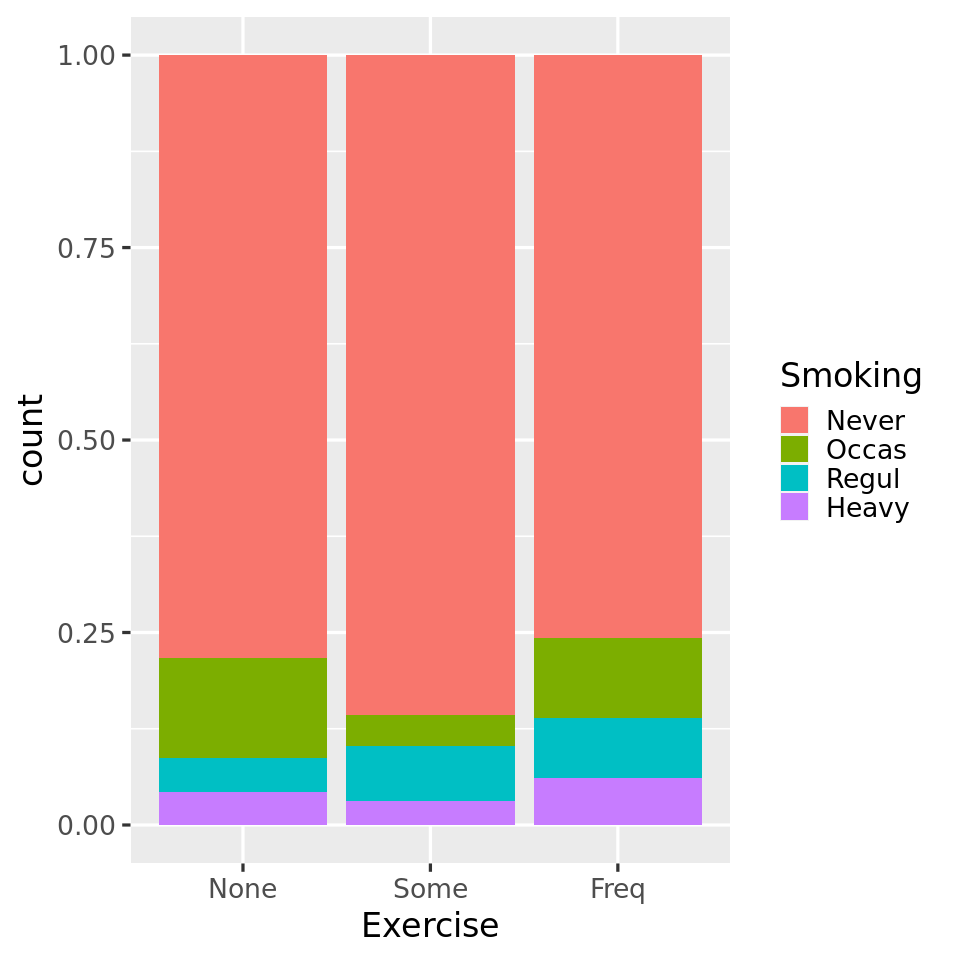

In [2]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

smoke_exercise %>% 
ggplot(aes(x=Exercise, fill=Smoking)) + 
  geom_bar(position="fill") +
  theme_grey(base_size=20)

Visually, we can see some differences in the distribution of smoking habits in the different categories of exercise. However, we do not know if these differences could be due to random chance

---
## How to quantify differences among the groups?

We can calculate the chi squared value based on the sum squared differences between the observed and expected counts in the table divided by the expected counts

$$\chi^{2}=\sum \frac{(\mathit{Observed}-\mathit{Expected})^{2}}{\mathit{Expected}}$$

The expected counts are calculated based on  
- how the row values are distributed according to the column margins
- how the column values are distributed according to the row margins

![test_count_chisq_calc.png](images/test_count_chisq_calc.png)

We will illustrate the calculation of the chi squared test statistic for the data

First, we will define a local function `print_table` to output a formatted table. We will then use the `table` function to create a cross table of counts

In [3]:
# cross-table convenience function
print_table <- function(input, margin=F) {
    
    if (margin == T) { input <- addmargins(input)}

    input <- htmlTable::txtRound(input,1)

    input %>% 
    htmlTable::htmlTable(css.rgroup = "font-weight: 900; text-align: left;") %>%
    IRdisplay::display_html() 
    
}

In [4]:
data_table <- table(smoke_exercise)

data_table %>% print_table()

Smoking 
 
 
 Never 
 Occas 
 Regul 
 Heavy 
 
 
 
 Exercise 
 
   None 
 18.0 
 3.0 
 1.0 
 1.0 
 
 
   Some 
 84.0 
 4.0 
 7.0 
 3.0 
 
 
   Freq 
 87.0 
 12.0 
 9.0 
 7.0

The expected values can be calculated by a matrix multiplication of the row (`e.g. R1, R2,..`) and column margins (`C1, C2,..`) and dividing the product by the total

We find the row margin totals as a 3x1 matrix

$$
R = \begin{bmatrix} a_1 \\ a_2 \\ \cdots\\ a_n
\end{bmatrix}
$$

In [5]:
row_margin <- data_table %>% 
              rowSums %>% 
              as.matrix

row_margin %>% print_table()

None,23.0
Some,98.0
Freq,115.0


We find the column margin totals as a 1x4 matrix

$$
C = \begin{bmatrix} b_1 & b_2 & \cdots & b_m
\end{bmatrix}
$$


In [6]:
col_margin <- data_table %>% 
              colSums %>% 
              as.matrix %>% 
              t

col_margin %>% print_table()

Never,Occas,Regul,Heavy
189.0,19.0,17.0,11.0


We calculate the expected values using the `%*%` matrix multiplication operator on both row and column margin matrices and dividing the products by the total count

$$
\begin{align}
RC &= \begin{bmatrix} a_1 \\ a_2 \\ \cdots\\ a_n
\end{bmatrix}
\begin{bmatrix} b_1 & b_2 & \cdots & b_m
\end{bmatrix}\\
&=\begin{bmatrix} a_1b_1 & a_1b_2 & \cdots & a_1b_m\\
a_2b_1 & a_2b_2 & \cdots & a_2b_m\\
\cdots & \cdots & \cdots & \cdots\\
a_nb_1 & a_nb_2 & \cdots & a_nb_m
\end{bmatrix}
\end{align}
$$


In [7]:
total_num <- sum(data_table)
expected <- row_margin %*% col_margin / total_num

expected %>% print_table()
data_table %>% print_table()

,Never,Occas,Regul,Heavy
None,18.4,1.9,1.7,1.1
Some,78.5,7.9,7.1,4.6
Freq,92.1,9.3,8.3,5.4


Smoking 
 
 
 Never 
 Occas 
 Regul 
 Heavy 
 
 
 
 Exercise 
 
   None 
 18.0 
 3.0 
 1.0 
 1.0 
 
 
   Some 
 84.0 
 4.0 
 7.0 
 3.0 
 
 
   Freq 
 87.0 
 12.0 
 9.0 
 7.0

We can now calculate the chi squared test statistic

$$\chi^{2}=\sum \frac{(O-E)^{2}}{E_{i}}$$

In [8]:
sum((data_table - expected)^2/expected)

[1] 5.488546

**Using a function**

We can use the `chisq_test` function from the `rstatix` library

```
rstatix::chisq_test(categorical_variable1 ~ categorical_variable2)
```

In [9]:
data_table %>% 
rstatix::chisq_test(Smoking ~ Exercise) %>% 
pull(statistic)

Warning message in stats::chisq.test(x, y, correct = correct, p = p, rescale.p = rescale.p, :
“Chi-squared approximation may be incorrect”


X-squared 
 5.488546

---
## 1. Resampling approach

To get an intuition of the null hypothesis test, we can use the resampling approach
- To do this, we randomly mix the categories among the groups and do this multiple times to generate a _dataset that represents the null hypothesis_
- We then calculate chi-squared statistic for each of the permutations generated by random mixing of the categories to generate the null distribution
- Finally, we calculate the _p-value_, which is the probability we find a chi-squared statistic in the null distribution that is equal/greater than what we observe in the data

$$P(\text{Data}|\text{Null distribution})$$

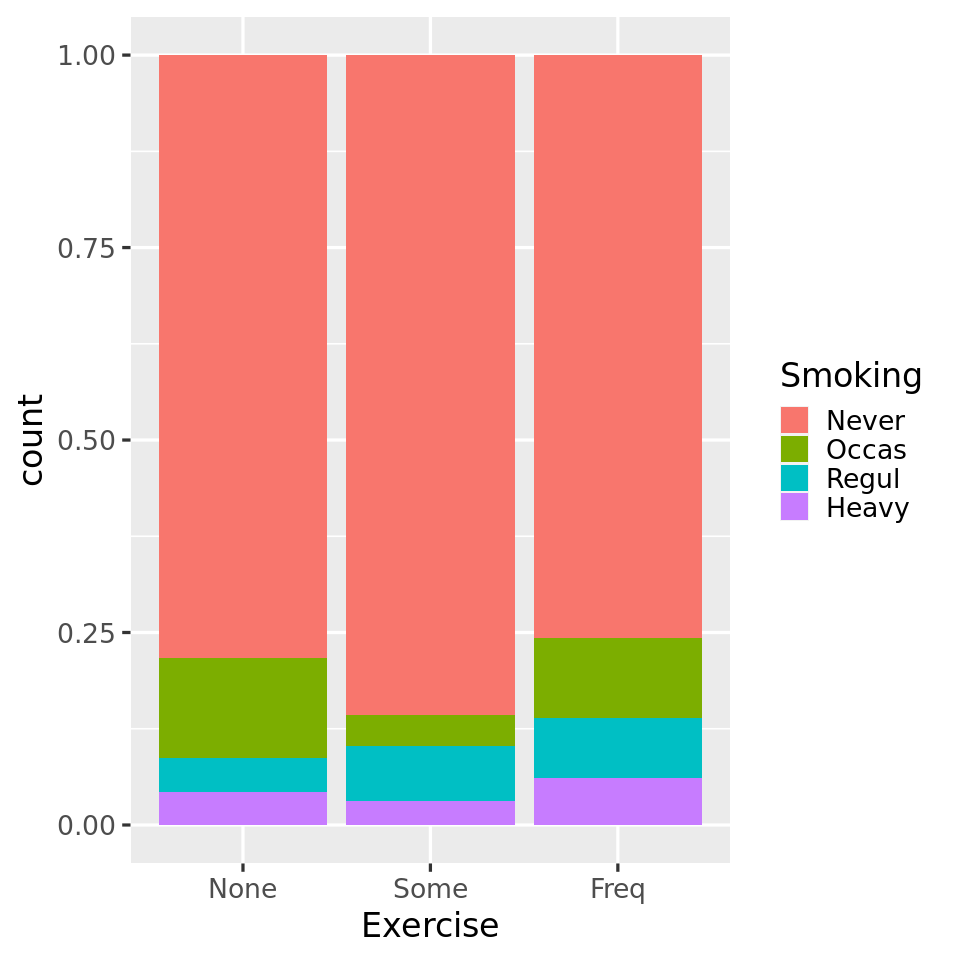

In [10]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

smoke_exercise %>% ggplot(aes(x=Exercise, fill=Smoking)) + 
                     geom_bar(position="fill") +
                     theme_grey(base_size=20)

### 1.1. Calculate the test statistic

We calculate the chi squared test statistic using the `chisq_test` function from the `rstatix` library

In [11]:
obs_stat_chisq <- data_table %>% 
                  rstatix::chisq_test(Smoking ~ Exercise) %>% 
                  pull(statistic)

obs_stat_chisq

Warning message in stats::chisq.test(x, y, correct = correct, p = p, rescale.p = rescale.p, :
“Chi-squared approximation may be incorrect”


X-squared 
 5.488546

### 1.2. Generate a null distribution by resampling

First, we will generate 1000 samples from the data by randomly permuting the counts using the `infer` library

In [12]:
library(infer)

num_resample <- 1000

permute <- smoke_exercise %>% 
           specify(Smoking ~ Exercise)  %>% 
           hypothesize(null = "independence") %>% 
           generate(reps = num_resample, type = "permute")

head(permute)
tail(permute)

Smoking,Exercise,replicate
<fct>,<fct>,<int>
Never,Some,1
Never,None,1
Never,None,1
Never,None,1
Never,Some,1
Never,Some,1


Smoking,Exercise,replicate
<fct>,<fct>,<int>
Never,Some,1000
Never,Some,1000
Never,Some,1000
Never,Some,1000
Never,Some,1000
Never,Freq,1000


We can plot a sample of the randomly permuted dataset

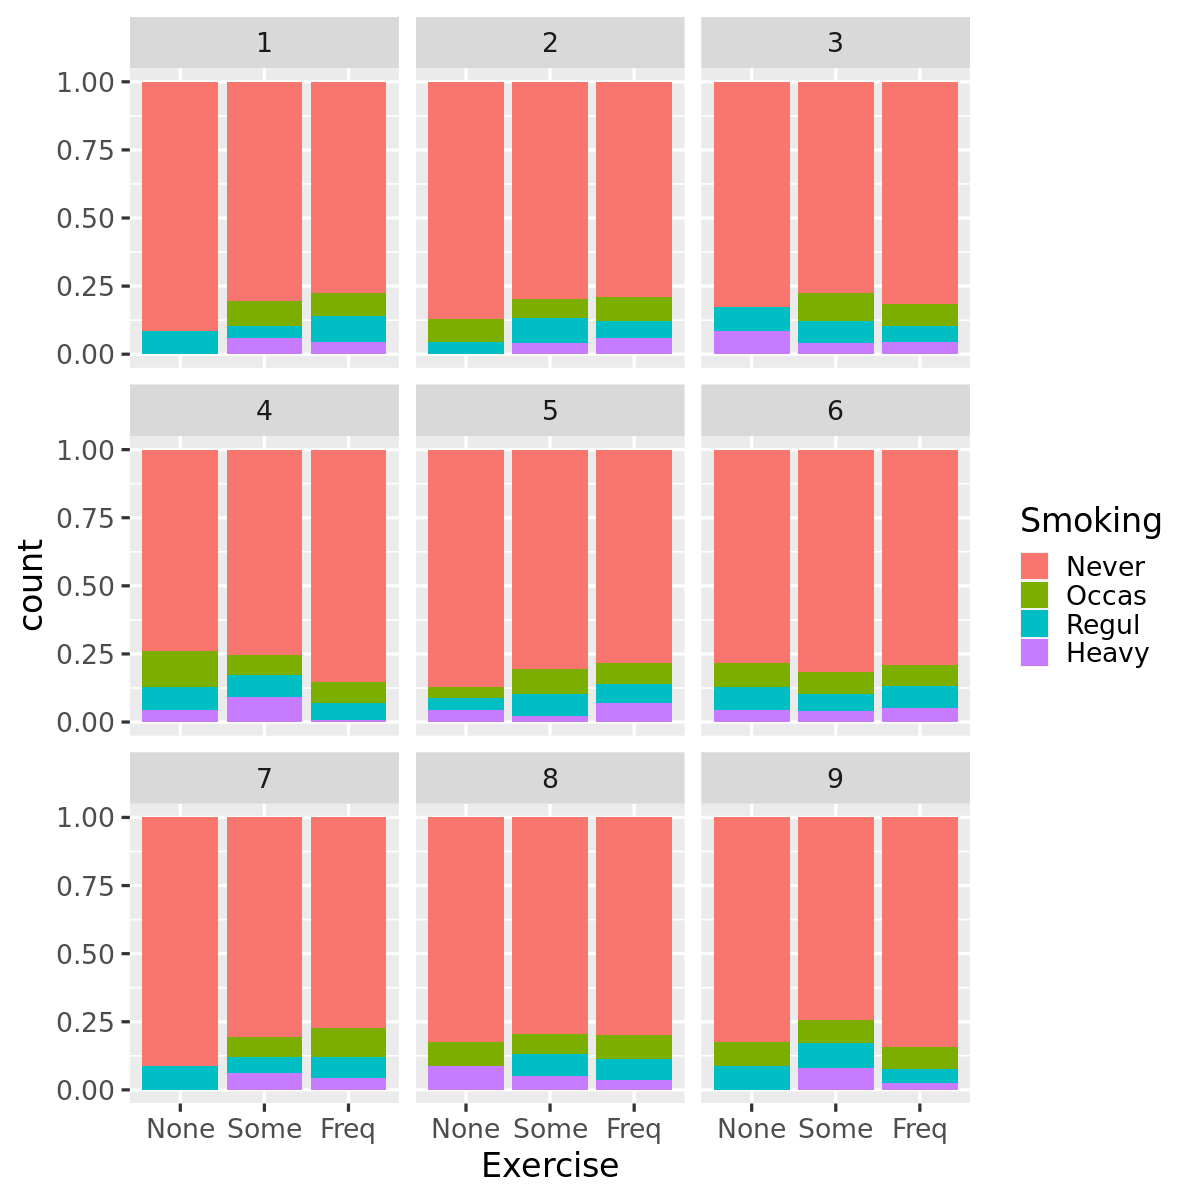

In [13]:
# set plot dimensions
options(repr.plot.width=10, repr.plot.height=10)

permute %>% 
filter(replicate <= 9) %>%
ggplot(aes(x=Exercise, fill=Smoking)) + 
  geom_bar(position="fill") + 
  facet_wrap(~replicate) +
  theme_grey(base_size=20) 

We calculate the chi squared test statistic for each replicate by using the `chisq_test` function from the `rstatix` library

In [14]:
resample <- permute %>% 
            group_by(replicate) %>% 
            group_modify( ~ {suppressWarnings(rstatix::chisq_test(table(.x$Smoking, .x$Exercise)))}) %>%
            ungroup %>%
            rename(stat=statistic) %>%
            select(replicate, stat)

head(resample)
tail(resample)

replicate,stat
<int>,<dbl>
1,6.3691677
2,2.9604377
3,3.8529197
4,9.8110891
5,3.8858194
6,0.5163457


replicate,stat
<int>,<dbl>
995,3.213288
996,4.693648
997,5.474474
998,2.155027
999,4.803756
1000,4.781850


We now have a distribution of chi squared test statistics under the assumption that there is no association between the 2 variables

### 1.3. Use the null distribution to calculate the p-value

Now that we have the chi squared null distribution, we can check if any of these values equal/exceed the observed chi squared statistic in the data ```obs_stat_chisq```

In [15]:
resample <- resample %>% 
            mutate(exceed = if_else(abs(stat) >= abs(obs_stat_chisq), "Y","N") %>%
                            factor(levels=c("Y","N")))

resample %>% sample_n(10)

replicate,stat,exceed
<int>,<dbl>,<fct>
722,2.043354,N
933,2.884526,N
382,4.683515,N
909,5.398551,N
540,6.313812,Y
188,4.837495,N
585,4.776013,N
934,3.431744,N
305,1.660539,N


We can visualize the distribution of chi squared statistic values and indicate those values that are equal or exceed the the observed chi squared statistic in the data

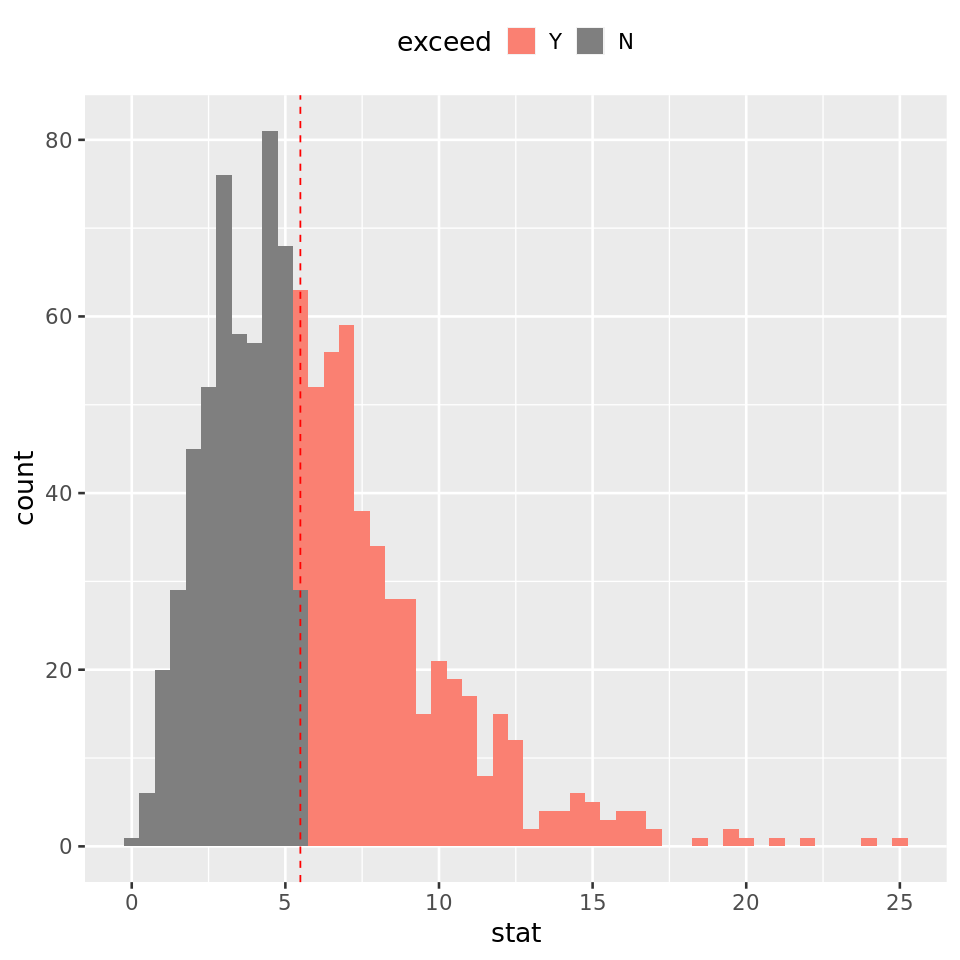

In [16]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

resample %>% 
ggplot(aes(x=stat, fill=exceed)) + 
  geom_histogram(binwidth=0.5) + 
  geom_vline(xintercept = obs_stat_chisq, color = "red", linetype="dashed") +
  scale_fill_manual(values=c("salmon", "grey50"), 
                 labels=c("Y","N"), drop=FALSE) +
  theme_grey(base_size=16) +
  theme(legend.position = "top")

Finally, we can get the _p-value_ by calculating how many times the chi square statistic in the null distribution is equal/exceeds the observed chi square statistic

In [17]:
resample %>% summarize(num_resample = n(),
                       num_exceed = if_else(exceed == "Y", 1,0) %>% sum,
                       p_value = num_exceed/num_resample)

num_resample,num_exceed,p_value
<int>,<dbl>,<dbl>
1000,478,0.478


We see that ~40-50% of the time, the null distribution is equal/exceeds the observed chi squared test statistic in the data. This indicates the observed data is consistent with the hypothesis that there is no association between the categories

---
## 2. Analytical approach

In the analytical approach, the null distribution is not derived from resampling, but it is calculated from a theoretical formula that generalizes the distribution

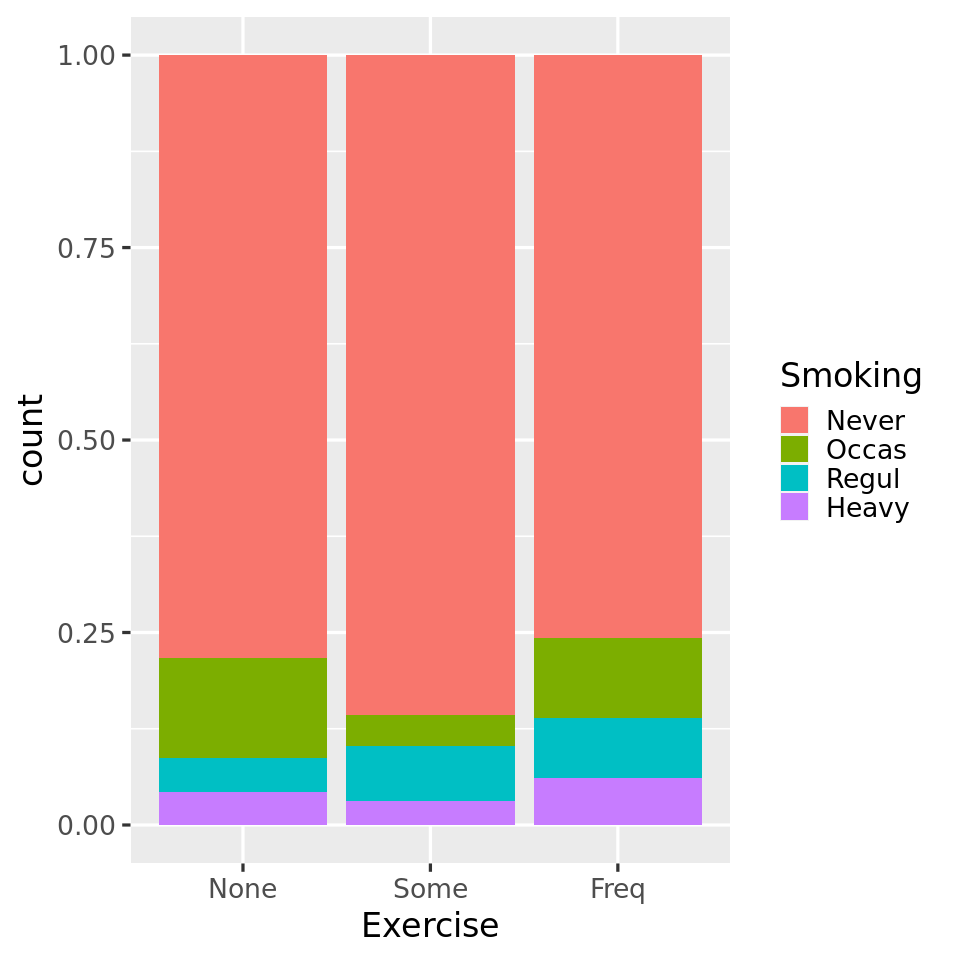

In [18]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

smoke_exercise %>% ggplot(aes(x=Exercise, fill=Smoking)) + 
                     geom_bar(position="fill") +
                     theme_grey(base_size=20)

### 2.1. Calculate the test statistic

We calculate the chi square test statistic using the `chisq_test` function from the `rstatix` library

In [19]:
obs_stat_chisq <- data_table %>% 
                  rstatix::chisq_test(Smoking ~ Exercise) %>% 
                  pull(statistic)

obs_stat_chisq

Warning message in stats::chisq.test(x, y, correct = correct, p = p, rescale.p = rescale.p, :
“Chi-squared approximation may be incorrect”


X-squared 
 5.488546

### 2.2. Use the theoretical null distribution to calculate the p-value

The null chi squared distribution is parameterized by the degrees of freedom `df`

- `df` = (number of rows - 1) * (number of columns - 1)


$$
\chi_{\mathit{df}}^{2}=\sum_{i=1}^{\mathit{df}} Z^{2} \text { where } Z \sim \operatorname{N}(0,1)
$$

In [20]:
df <- (nrow(data_table) - 1) * (ncol(data_table) - 1)

df

[1] 6

We use the `vdist_chisquare_prob` function from `vistributions` library to plot the chi squared distribution and calculate the p-value

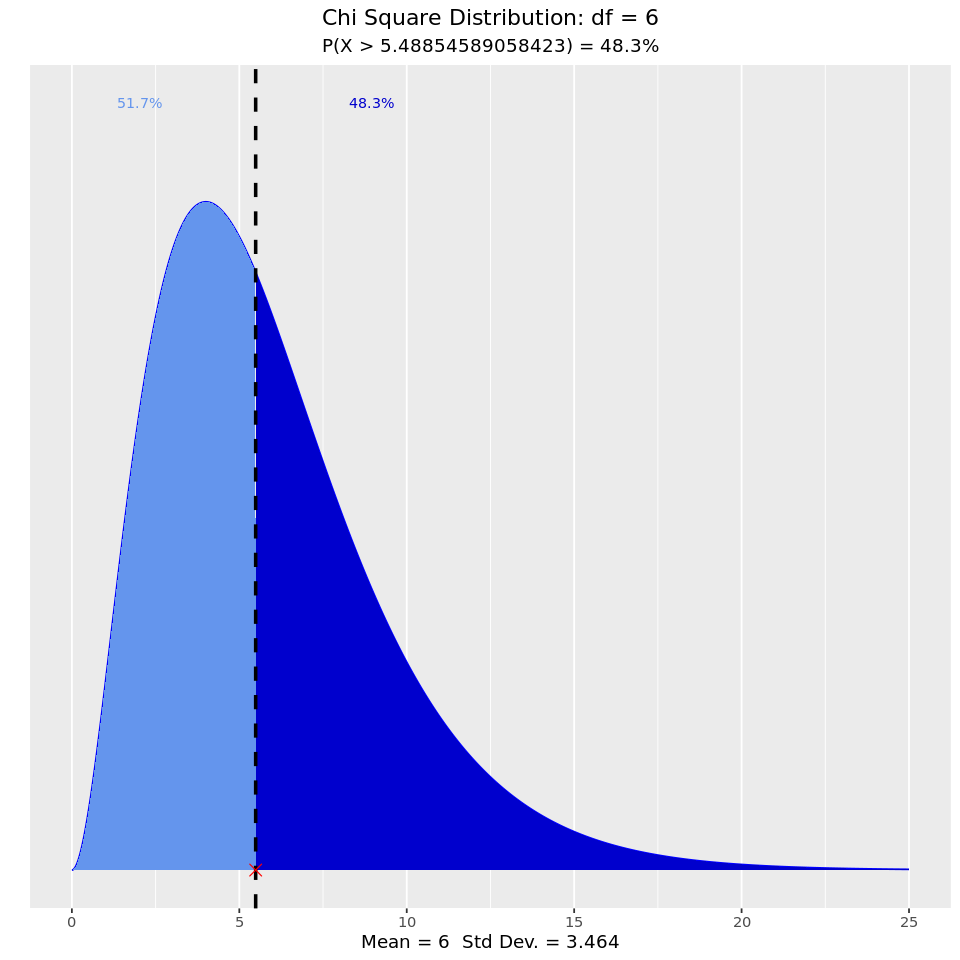

In [21]:
library(vistributions)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

vdist_chisquare_prob(perc = obs_stat_chisq, 
                     df=df, 
                     type = "upper")

We see that the p-value is 0.48, which is close to the value we obtained through resampling

**Using a function**

We can also use the `chisq_test` function from the `rstatix` library

In [22]:
data_table %>% rstatix::chisq_test()

Warning message in stats::chisq.test(x, y, correct = correct, p = p, rescale.p = rescale.p, :
“Chi-squared approximation may be incorrect”


,n,statistic,p,df,method,p.signif
,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,236,5.488546,0.483,6,Chi-square test,ns


---
## Effect size

In [23]:
print_table(data_table)

Smoking 
 
 
 Never 
 Occas 
 Regul 
 Heavy 
 
 
 
 Exercise 
 
   None 
 18.0 
 3.0 
 1.0 
 1.0 
 
 
   Some 
 84.0 
 4.0 
 7.0 
 3.0 
 
 
   Freq 
 87.0 
 12.0 
 9.0 
 7.0

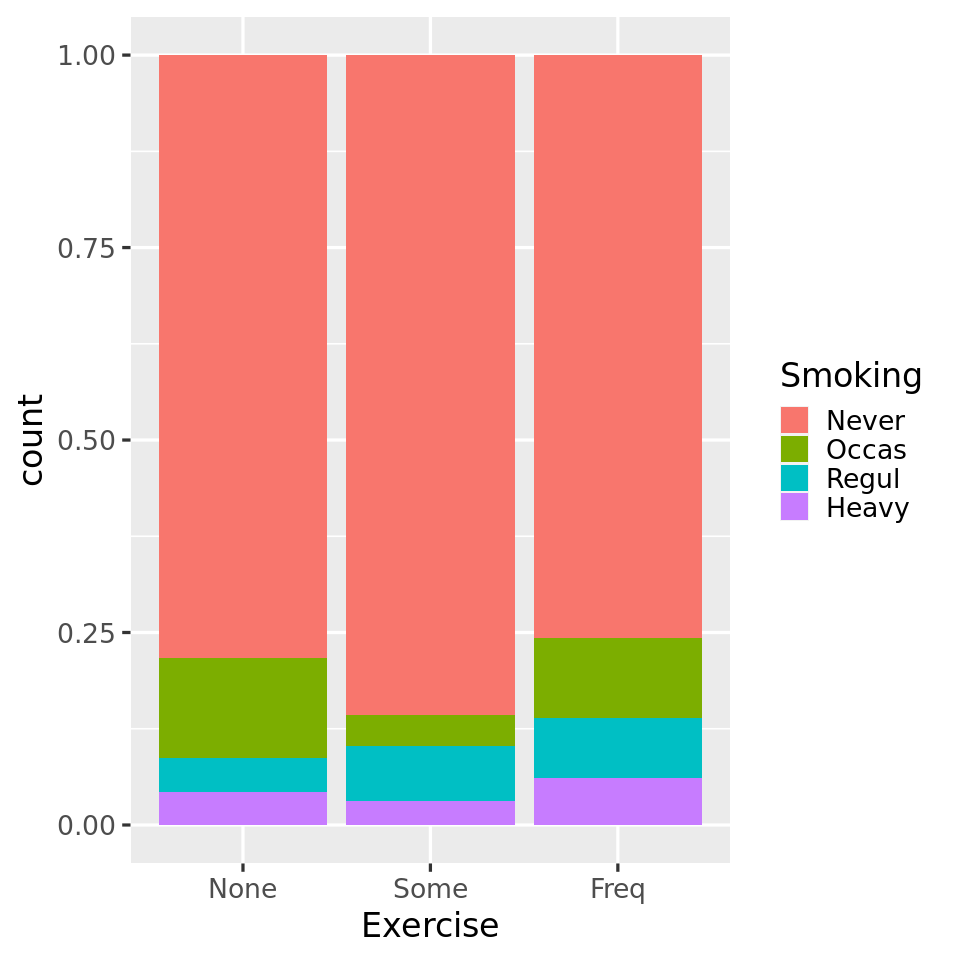

In [24]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

smoke_exercise %>% 
ggplot(aes(x=Exercise, fill=Smoking)) + 
  geom_bar(position="fill") +
  theme_grey(base_size=20)

The effect size for counts in an R x C table is defined by Cramer's $V$

$$
V=\sqrt{\frac{\chi^{2} / n}{\min (n_{rows}-1, n_{columns}-1)}}
$$

In [25]:
chi_sq <- data_table %>% 
          rstatix::chisq_test() %>% 
          pull(statistic) %>% as.numeric()

n <- sum(data_table)
min_df <- min(nrow(data_table)-1, ncol(data_table)-1)

sqrt((chi_sq/n)/min_df)

Warning message in stats::chisq.test(x, y, correct = correct, p = p, rescale.p = rescale.p, :
“Chi-squared approximation may be incorrect”


[1] 0.1078345

**Using a function**

We can use the `cramers_v` function from the `effectsize` library

In [26]:
effectsize::cramers_v(data_table)

Registered S3 method overwritten by 'parameters':
  method                         from      
  format.parameters_distribution datawizard



Cramers_v,CI,CI_low,CI_high
<dbl>,<dbl>,<dbl>,<dbl>
0.1078345,0.95,0,1


Cramer's V can overestimate the effect size of an association. To correct for this bias, we can include the `adjust=T` option

In [27]:
effectsize::cramers_v(data_table, adjust = T)

Cramers_v_adjusted,CI,CI_low,CI_high
<dbl>,<dbl>,<dbl>,<dbl>
0,0.95,0,1


---
# Application: Statistical plotting

We will use the `ggstatsplot` library. For details see: https://indrajeetpatil.github.io/ggstatsplot/

In [ ]:
library(ggstatsplot)

We will use the same survey dataset looking at smoking and exercise

We can look at the crosstable by using the `table` function and passing it to our local `print_table` function for formatting

In [ ]:
library(tidyverse)

data <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/survey.csv")

smoke_exercise <- data %>% 
                  mutate(Smoke = fct_relevel(Smoke, c("Never","Occas","Regul","Heavy")),
                         Exer = fct_relevel(Exer, c("None","Some","Freq"))) %>%
                         rename(Smoking=Smoke, Exercise=Exer) %>%
                         select(Exercise, Smoking) %>%
                  drop_na()

head(smoke_exercise)

In [ ]:
# cross-table convenience function
print_table <- function(input, margin=F) {
    
    if (margin == T) { input <- addmargins(input)}

    input <- htmlTable::txtRound(input,1)

    input %>% 
    htmlTable::htmlTable(css.rgroup = "font-weight: 900; text-align: left;") %>%
    IRdisplay::display_html() 
    
}


In [ ]:
table(smoke_exercise) %>% print_table()

We will make a plot comparing counts for >2x2 categories with parametric chi-squared test using the `ggbarstats` function from `ggstatsplot`
- `x`: column label in table (dependent)
- `y`: row label in table (independent)

For details, see: https://indrajeetpatil.github.io/ggstatsplot/reference/ggbarstats.html

In [ ]:
# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

smoke_exercise %>% 
ggbarstats(x=Smoking, 
           y=Exercise) +
  theme_grey(base_size=16)

---
## Exercise - Comparing counts > 2x2 categories

For this exercise, we will use the Framingham heart dataset

In [ ]:
library(tidyverse)

# load data
data_plot <- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# recap of what was done
data_plot <- data_plot %>% 
             rename(sex = male) %>%
             mutate(sex = as.factor(sex),
                    age = as.integer(age),
                    education = as.factor(education),
                    currentSmoker = as.factor(currentSmoker),
                    cigsPerDay = as.integer(cigsPerDay),
                    BPMeds = as.factor(BPMeds),
                    prevalentStroke = as.factor(prevalentStroke),
                    prevalentHyp = as.factor(prevalentHyp),
                    diabetes = as.factor(diabetes),
                    totChol = as.integer(totChol),
                    heartRate = as.integer(heartRate),
                    TenYearCHD = as.factor(TenYearCHD)
                    )

data_plot <- data_plot %>% 
             mutate(glucose = round(glucose/18, digits=1)) %>% # mg/dL to mmol/L
             mutate(totChol = round(totChol/39, digits=1))     # mg/dL to mmol/L

head(data_plot)

We will define a local function `print_table` to output a formatted table

In [ ]:
# cross-table convenience function
print_table <- function(input, margin=F) {
    
    if (margin == T) { input <- addmargins(input)}

    input <- htmlTable::txtRound(input,1)

    input %>% 
    htmlTable::htmlTable(css.rgroup = "font-weight: 900; text-align: left;") %>%
    IRdisplay::display_html() 
    
}

### Part 1

Create a table of counts for the `education` and `TenYearCHD` variables and print it
- `education` as row label
- `TenYearCHD` as column label

In [ ]:
# start here

In [ ]:
# solution

data_plot %>% 
select(education, TenYearCHD) %>% 
table() %>% 
print_table()

### Part 2

Generate a statistical plot showing the different proportions of patients with/without chronic heart disease `(TenYearCHD)` by `education` using `ggbarstats` from `ggstatsplot`
- State the effect size, 95% CI and the p-value

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

library(ggstatsplot)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

data_plot %>% 
ggbarstats(x=TenYearCHD,
           y=education) +
  theme_classic(base_size=16)